In [ ]:
import numpy as np                                     # 넘파이 패키지
import pandas as pd                                    # 판다스 패키지
import matplotlib.pyplot as plt                        # 그래프 패키지

from sklearn.linear_model import LinearRegression      # 선형 회귀 패키지
from sklearn.linear_model import Ridge                 # 릿지 선형 회귀 패키지
from sklearn.preprocessing import PolynomialFeatures   # 특성 변환기 패키지

import tensorflow as tf                                # 인공지능 패키지
from keras.models import Sequential, Model
from keras import optimizers

from keras.layers import Dense, Input, Concatenate, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_absolute_error        # 평균 절대값 에러(모델 평가 지수)
from sklearn.metrics import mean_squared_error         # 평균 제곱근 에러(모델 평가 지수)

In [ ]:
# 코랩과 구굴 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')   # content는 내 드라이브 디렉토리입니다.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/week12/mokpo_data.csv')
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30624 entries, 0 to 30623
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기온      30624 non-null  float64
 1   풍속      30624 non-null  float64
 2   습도      30624 non-null  int64  
 3   기압      30624 non-null  float64
 4   일조      30624 non-null  float64
 5   일사      30624 non-null  float64
 6   전운량     30624 non-null  int64  
 7   발전량     30624 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.9 MB
None
    기온   풍속  습도      기압   일조  일사   전운량  발전량
0 -3.6  1.9  66  1027.7  0.0  0.0    9  0.0
1 -4.4  2.3  66  1027.6  0.0  0.0    6  0.0
2 -4.1  2.1  65  1028.1  0.0  0.0    9  0.0
3 -4.0  1.1  63  1028.0  0.0  0.0    9  0.0
4 -4.2  1.3  63  1027.5  0.0  0.0    9  0.0


In [ ]:
data = np.array(data)          # 데이터 프레임을 배열로 변환
# 정규화 : 각 열 단위로 0 부터 1롤 변환
data = (data - np.min(data, 0)) / (np.max(data, 0) - np.min(data, 0))
print(data.shape)              # 데이터 스케일 보기
print(data[0 : 5])             #
print(len(data) * 0.8)         # 데이터 나누기 위해서

(30624, 8)
[[0.1991342  0.08920188 0.61363636 0.89668616 0.         0.
  0.9        0.        ]
 [0.18181818 0.10798122 0.61363636 0.89473684 0.         0.
  0.6        0.        ]
 [0.18831169 0.09859155 0.60227273 0.90448343 0.         0.
  0.9        0.        ]
 [0.19047619 0.05164319 0.57954545 0.90253411 0.         0.
  0.9        0.        ]
 [0.18614719 0.06103286 0.57954545 0.89278752 0.         0.
  0.9        0.        ]]
24499.2


In [ ]:
# 데이터셋 만들기(주의 : 다음 시간 예측입니다)
x_data = data[ : -1, : ]             # 입력 데이터(마지막 샘플 전까지)
y_data = data[1 : , -1]              # 타겟 데이터(다음날 부터 마지막 샘플까지)
print(x_data.shape)
print(y_data.shape)

(30623, 8)
(30623,)


In [ ]:
# 데이터 셋 만들기
x_train = x_data[ : 24499 ,  : ]         # 학습 데이터
y_train = y_data[ : 24499]

x_test = x_data[24499 : ,  : ]          # 테스트 데이터
y_test = y_data[24499 :]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(24499, 8)
(24499,)
(6124, 8)
(6124,)


##입력 특성 늘리기
degree=4

In [ ]:
poly = PolynomialFeatures(degree=4, include_bias=False)   # 특성 변환기 모델
poly.fit(x_train)                                         # 4개의 특성을 이용하여 특성을 늘리는 학습

train_poly = poly.transform(x_train)                      # 여기서 훈련 셋 특성 변함
test_poly = poly.transform(x_test)                        # 테스트 셋도 훈련셋과 동일

print(train_poly.shape)                                   # 특성 변환 스케일

(24499, 494)


In [ ]:
lr = LinearRegression()                              # 선형 회귀 모델
lr.fit(train_poly, y_train)                    # 모델 훈련
print(lr.score(train_poly, y_train))           # 훈련 셋 평가
print(lr.score(test_poly, y_test))             # 테스트 셋 평가

0.9154697941620649
0.901271712432788


In [ ]:
# 테스트 세트에 대한 예측 값
test_prediction = lr.predict(test_poly)
# 테스트 세트에 대한 평균 절댓값 오차를 계산합니다
mae = mean_absolute_error(y_test, test_prediction)
mse = mean_squared_error(y_test, test_prediction)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

0.044103830193034564
0.006279905011637385
0.07924585169986745


##인공신경망 다중회귀

In [ ]:
input = Input(shape=(494,))                               # 입력층
hidden1 = Dense(256, activation='relu')(input)          # 1 층
hidden2 = Dense(256, activation='relu')(hidden1)        # 2 층
hidden3 = Dense(256, activation='relu')(hidden2)        # 3 층
hidden4 = Dense(256, activation='relu')(hidden3)        # 4층
hidden5 = Dense(256, activation='relu')(hidden4)        # 5층
hidden6 = Dense(256, activation='relu')(hidden5)        # 6층
output = Dense(1, activation='linear')(hidden6)      # 출력 층

model_DNN = Model(input, output)      # 모델 구축
model_DNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 494)]             0         
                                                                 
 dense (Dense)               (None, 256)               126720    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 256)               65792 

In [ ]:
# 모델 학습과정 설정하기
model_DNN.compile(loss = 'mse', optimizer = optimizers.Adam(0.001), metrics=['accuracy'])
monitor_val_lose = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)

In [ ]:
# 모델 학습
hist = model_DNN.fit(
train_poly, y_train,                               # 입력 / 라벨
epochs = 20, batch_size = 10,                   # 학습 회수 / 10개 샘플마다 학습
validation_data=(test_poly, y_test),               # 검증 데이터
callbacks = [monitor_val_lose]  # 저장 및 모니터링
)

Epoch 1/20
2450/2450 [==============================] - 16s 5ms/step - loss: 0.0070 - accuracy: 0.4849 - val_loss: 0.0094 - val_accuracy: 0.5536
Epoch 2/20
2450/2450 [==============================] - 13s 5ms/step - loss: 0.0057 - accuracy: 0.4849 - val_loss: 0.0064 - val_accuracy: 0.5536
Epoch 3/20
2450/2450 [==============================] - 13s 5ms/step - loss: 0.0054 - accuracy: 0.4849 - val_loss: 0.0066 - val_accuracy: 0.5536
Epoch 4/20
2450/2450 [==============================] - 14s 6ms/step - loss: 0.0054 - accuracy: 0.4849 - val_loss: 0.0067 - val_accuracy: 0.5536
Epoch 5/20
2450/2450 [==============================] - 12s 5ms/step - loss: 0.0052 - accuracy: 0.4849 - val_loss: 0.0063 - val_accuracy: 0.5536
Epoch 6/20
2450/2450 [==============================] - 12s 5ms/step - loss: 0.0051 - accuracy: 0.4849 - val_loss: 0.0064 - val_accuracy: 0.5536
Epoch 7/20
2450/2450 [==============================] - 12s 5ms/step - loss: 0.0050 - accuracy: 0.4849 - val_loss: 0.0064 - val_ac

In [ ]:
predict = model_DNN.predict(test_poly)

mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

192/192 [==============================] - 0s 2ms/step
0.04428654702763166
0.006241772280838609
0.0790048877022087


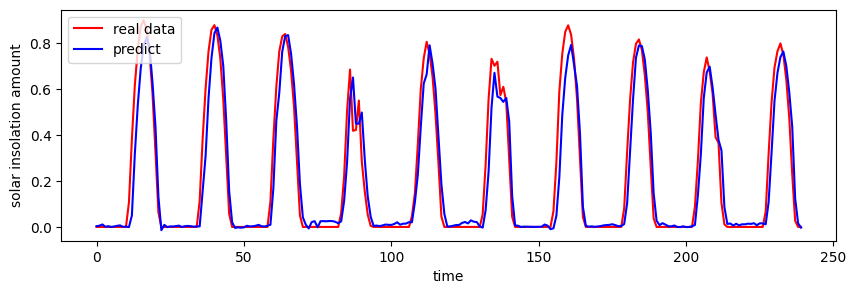

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(y_test[0 : 240], 'r', label = 'real data')   # 실제값 출력
plt.plot(predict[00 : 240], 'b', label = 'predict')    # 예측값 출력
plt.xlabel("time")
plt.ylabel("solar insolation amount")
plt.legend(loc='upper left')
plt.show()

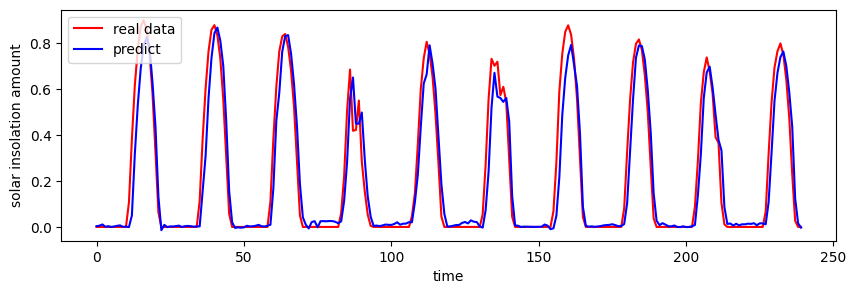

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(y_test[0 : 240], 'r', label = 'real data')   # 실제값 출력
plt.plot(predict[00 : 240], 'b', label = 'predict')    # 예측값 출력
plt.xlabel("time")
plt.ylabel("solar insolation amount")
plt.legend(loc='upper left')
plt.show()

## DNN 병렮 모델

In [ ]:
from keras.layers import concatenate                    # 두 출력을 연결

inputA = Input(shape=(494,))                            # 입력층
hidden1 = Dense(128, activation='relu')(input)          # 1 층
hidden2 = Dense(128, activation='relu')(hidden1)        # 2 층
hidden3 = Dense(128, activation='relu')(hidden2)        # 3 층
outputA = Dense(16, activation='linear')(hidden6)       # 출력 층

inputB = Input(shape=(494,))                            # 입력층
hidden1 = Dense(128, activation='relu')(input)          # 1 층
hidden2 = Dense(128, activation='relu')(hidden1)        # 2 층
hidden3 = Dense(128, activation='relu')(hidden2)        # 3 층
outputB = Dense(16, activation='linear')(hidden6)       # 출력 층

# 두개의 인공 신경망의 출력을 연결(concatenate)
result = concatenate([inputA, inputB])

z = Dense(8, activation = "relu")(result)

z = Dense(1, activation = "linear")(z)
model_DNN = Model(inputs = [inputA, inputB], outputs = z)
model_DNN.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 494)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 494)]                0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 988)                  0         ['input_8[0][0]',             
 )                                                                   'input_9[0][0]']             
                                                                                                  
 dense_43 (Dense)            (None, 8)                    7912      ['concatenate_1[0][0]'] 

In [ ]:
# 모델 학습과정 설정하기
model_DNN.compile(loss = 'mse', optimizer = optimizers.SGD(0.001), metrics=['accuracy'])

monitor_val_lose = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)

In [ ]:
# 모델 학습
hist = model_DNN.fit(
                    [train_poly, train_poly], y_train,                               # 입력 / 라벨
                     epochs = 20, batch_size = 10,                   # 학습 회수 / 10개 샘플마다 학습
                     validation_data=([test_poly, test_poly], y_test),               # 검증 데이터
                     callbacks = [monitor_val_lose]  # 저장 및 모니터링
                    )

Epoch 1/20
2450/2450 [==============================] - 10s 4ms/step - loss: 0.0138 - accuracy: 0.4849 - val_loss: 0.0112 - val_accuracy: 0.5536
Epoch 2/20
2450/2450 [==============================] - 8s 3ms/step - loss: 0.0086 - accuracy: 0.4849 - val_loss: 0.0100 - val_accuracy: 0.5536
Epoch 3/20
2450/2450 [==============================] - 9s 4ms/step - loss: 0.0078 - accuracy: 0.4849 - val_loss: 0.0095 - val_accuracy: 0.5536
Epoch 4/20
2450/2450 [==============================] - 9s 4ms/step - loss: 0.0073 - accuracy: 0.4849 - val_loss: 0.0090 - val_accuracy: 0.5536
Epoch 5/20
2450/2450 [==============================] - 8s 3ms/step - loss: 0.0070 - accuracy: 0.4849 - val_loss: 0.0088 - val_accuracy: 0.5536
Epoch 6/20
2450/2450 [==============================] - 9s 4ms/step - loss: 0.0068 - accuracy: 0.4849 - val_loss: 0.0085 - val_accuracy: 0.5536
Epoch 7/20
2450/2450 [==============================] - 10s 4ms/step - loss: 0.0066 - accuracy: 0.4849 - val_loss: 0.0085 - val_accurac

In [ ]:
predict = model_DNN.predict([test_poly, test_poly])

mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

192/192 [==============================] - 0s 2ms/step
0.050780134627338484
0.007265724593979773
0.0852392198109519


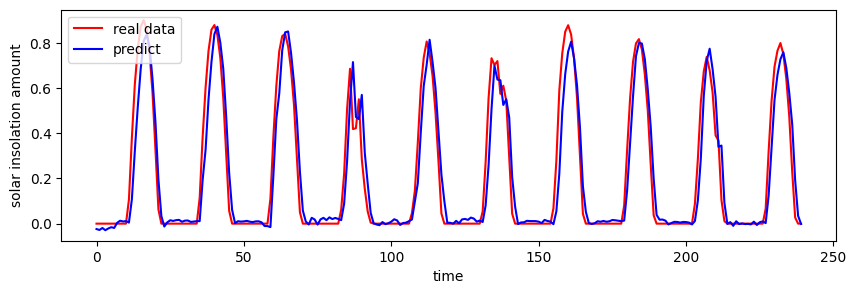

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(y_test[0 : 240], 'r', label = 'real data')   # 실제값 출력
plt.plot(predict[00 : 240], 'b', label = 'predict')    # 예측값 출력
plt.xlabel("time")
plt.ylabel("solar insolation amount")
plt.legend(loc='upper left')
plt.show()

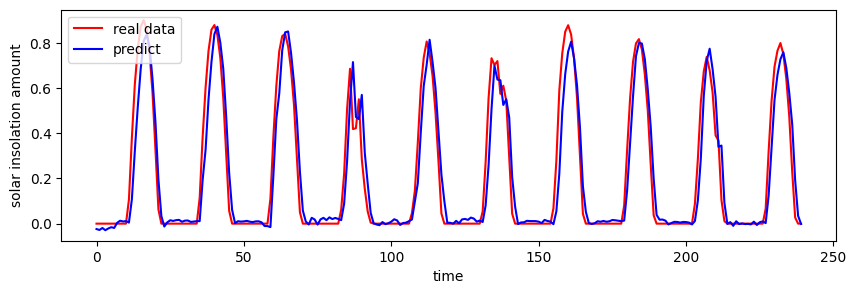

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(y_test[0 : 240], 'r', label = 'real data')   # 실제값 출력
plt.plot(predict[00 : 240], 'b', label = 'predict')    # 예측값 출력
plt.xlabel("time")
plt.ylabel("solar insolation amount")
plt.legend(loc='upper left')
plt.show()

##LSTM 모델로 예측하기

In [ ]:
x_data = data[ : -1, : ]             # 입력 데이터(마지막 샘플 전까지)
y_data = data[1 : , -1]              # 타겟 데이터(다음날 부터 마지막 샘플까지)
print(x_data.shape)
print(y_data.shape)
print(x_data.shape)
print(y_data.shape)

(30623, 8)
(30623,)
(30623, 8)
(30623,)


In [ ]:
poly = PolynomialFeatures(degree=4, include_bias=False)   # 특성 변환기 모델
poly.fit(x_data)                                          # 3개의 특성을 이용하여 특성을 늘리는 학습

data_poly = poly.transform(x_data)                        # 여기서 훈련 셋 특성 변함

print(data_poly.shape)                                    # 특성 변환 스케알

(30623, 494)


In [ ]:
x_data = []                         # 입력데이터 리스트
y_data = []                         # 출력데이터 리스트

for i in range(1, len(data_poly) - 24) :
  x = data_poly[i : i + 24, : ]
  y = data_poly[i + 24, [-1]]
  x_data.append(x)
  y_data.append(y)

x_data = np.array(x_data)
y_data = np.array(y_data)

print(x_data.shape)
print(y_data.shape)

(30598, 24, 494)
(30598, 1)


In [ ]:
# 데이터 셋 만들기
x_train = x_data[ : 24499 ,  : ]         # 학습 데이터
y_train = y_data[ : 24499]

x_test = x_data[24499 : ,  : ]          # 테스트 데이터
y_test = y_data[24499 :]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(24499, 24, 494)
(24499, 1)
(6099, 24, 494)
(6099, 1)


In [ ]:
inputs = Input(shape=(24, 494))
lstm_layer = LSTM(128)(inputs)
hidden1 = Dense(128, activation='relu')(lstm_layer)
outputs = Dense(1, activation='linear')(hidden1)
model_LSTM = Model(inputs = inputs, outputs = outputs)
model_LSTM.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 24, 494)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               318976    
                                                                 
 dense_45 (Dense)            (None, 128)               16512     
                                                                 
 dense_46 (Dense)            (None, 1)                 129       
                                                                 
Total params: 335617 (1.28 MB)
Trainable params: 335617 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일 하기
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)
model_LSTM.compile(loss = 'mse', optimizer = optimizers.Adam(0.001), metrics=['accuracy'])

In [ ]:
hist = model_LSTM.fit(
                  x_train, y_train,
                  epochs = 20, batch_size = 10,
                  validation_data=(x_test, y_test),
                  callbacks = [early_stopping]
                 )

Epoch 1/20
2450/2450 [==============================] - 20s 7ms/step - loss: 0.0019 - accuracy: 0.4847 - val_loss: 0.0051 - val_accuracy: 0.5535
Epoch 2/20
2450/2450 [==============================] - 16s 7ms/step - loss: 0.0013 - accuracy: 0.4847 - val_loss: 0.0016 - val_accuracy: 0.5535
Epoch 3/20
2450/2450 [==============================] - 17s 7ms/step - loss: 0.0012 - accuracy: 0.4847 - val_loss: 0.0011 - val_accuracy: 0.5535
Epoch 4/20
2450/2450 [==============================] - 15s 6ms/step - loss: 0.0011 - accuracy: 0.4847 - val_loss: 9.5286e-04 - val_accuracy: 0.5535
Epoch 5/20
2450/2450 [==============================] - 16s 6ms/step - loss: 0.0011 - accuracy: 0.4847 - val_loss: 0.0012 - val_accuracy: 0.5535
Epoch 6/20
2450/2450 [==============================] - 15s 6ms/step - loss: 0.0011 - accuracy: 0.4847 - val_loss: 0.0014 - val_accuracy: 0.5535
Epoch 7/20
2450/2450 [==============================] - 15s 6ms/step - loss: 0.0011 - accuracy: 0.4847 - val_loss: 0.0011 - va

In [ ]:
predict = model_LSTM.predict(x_test)

mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

191/191 [==============================] - 1s 3ms/step
0.01587673732958283
0.0010730156515516367
0.032756917613713854


##BiLSTM 모델로 예측하기

In [ ]:
inputs = Input(shape=(24, 494))
lstm_layer = Bidirectional(LSTM(128))(inputs)
hidden1 = Dense(128, activation='relu')(lstm_layer)
outputs = Dense(1, activation='linear')(hidden1)
model_BiLSTM = Model(inputs = inputs, outputs = outputs)
model_BiLSTM.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24, 494)]         0         
                                                                 
 bidirectional (Bidirection  (None, 256)               637952    
 al)                                                             
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 670977 (2.56 MB)
Trainable params: 670977 (2.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일 하기
model_checkpoint = ModelCheckpoint(filepath =  "./model/LSTM.h5", monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)

# 모델 학습과정 설정하기
model_BiLSTM.compile(loss = 'mse', optimizer = optimizers.Adam(0.001), metrics=['accuracy'])

In [ ]:
hist = model_BiLSTM.fit(
                  x_train, y_train,
                  epochs = 20, batch_size = 10,
                  validation_data=(x_test, y_test),
                  callbacks = [model_checkpoint, early_stopping]
                 )

Epoch 1/20
2446/2450 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.4849
Epoch 1: val_loss improved from inf to 0.00132, saving model to ./model/LSTM.h5
2450/2450 [==============================] - 27s 9ms/step - loss: 0.0022 - accuracy: 0.4847 - val_loss: 0.0013 - val_accuracy: 0.5535
Epoch 2/20
  17/2450 [..............................] - ETA: 16s - loss: 9.5050e-04 - accuracy: 0.5059

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2446/2450 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.4847
Epoch 2: val_loss improved from 0.00132 to 0.00108, saving model to ./model/LSTM.h5
2450/2450 [==============================] - 22s 9ms/step - loss: 0.0013 - accuracy: 0.4847 - val_loss: 0.0011 - val_accuracy: 0.5535
Epoch 3/20
2445/2450 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.4845
Epoch 3: val_loss did not improve from 0.00108
2450/2450 [==============================] - 20s 8ms/step - loss: 0.0012 - accuracy: 0.4847 - val_loss: 0.0011 - val_accuracy: 0.5535
Epoch 4/20
2447/2450 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.4846
Epoch 4: val_loss did not improve from 0.00108
2450/2450 [==============================] - 22s 9ms/step - loss: 0.0011 - accuracy: 0.4847 - val_loss: 0.0014 - val_accuracy: 0.5535
Epoch 5/20
2448/2450 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.4848
Epoch 5: val_loss improved from 0.00108

In [ ]:
predict = model_BiLSTM.predict(x_test)

mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

191/191 [==============================] - 2s 4ms/step
0.010486812816828645
0.0008998677036124752
0.02999779497917264


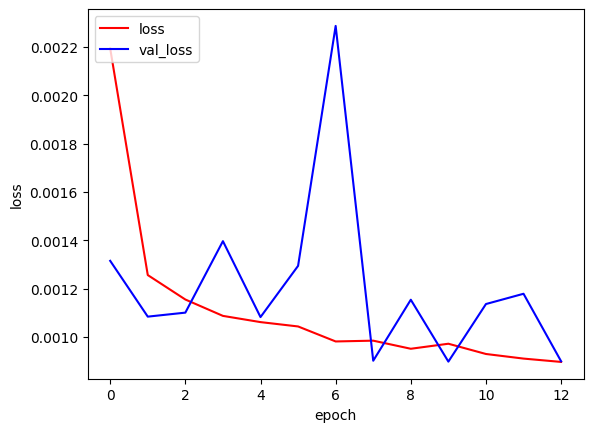

In [ ]:
# 그래프 출력
import matplotlib.pyplot as plt
# 과정 살펴보기
plt.plot(hist.history['loss'], 'r', label = 'loss')
plt.plot(hist.history['val_loss'], 'b', label = 'val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

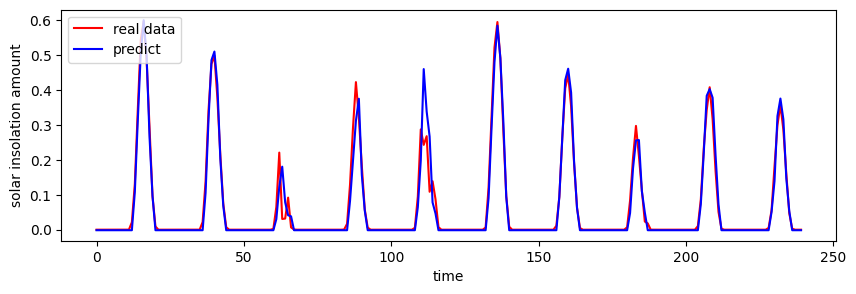

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(y_test[0 : 240], 'r', label = 'real data')   # 실제값 출력
plt.plot(predict[00 : 240], 'b', label = 'predict')    # 예측값 출력
plt.xlabel("time")
plt.ylabel("solar insolation amount")
plt.legend(loc='upper left')
plt.show()